# Importing libraries

In [1]:
import os
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA              

C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return

# Generating RDKit descriptors

In [3]:
# import pandas as pd
# import numpy as np

# X_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
# X_train = X_train.drop(['PCE_max(%)'], axis = 1)
# X_train

# X_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
# X_val = X_val.drop(['PCE_max(%)'], axis = 1)
# X_val

# X_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
# X_test = X_test.drop(['PCE_max(%)'], axis = 1)
# X_test

# # rdkit desciptors for test set


# from rdkit.Chem import Descriptors
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole

# from rdkit.ML.Descriptors import MoleculeDescriptors
# des_list = [x[0] for x in Descriptors._descList]


# def rdkit_des(D,A):

#     mols = [ Chem.MolFromSmiles(x) for x in D_smiles if x != None ]
#     desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
#     values_rdkit_donor = [desc_calc.CalcDescriptors(mol) for mol in mols]
#     values_rdkit_donor

#     df_rdkit_donor = pd.DataFrame(values_rdkit_donor, columns=des_list)
#     df_rdkit_donor

#     df_rdkit_donor=df_rdkit_donor.add_prefix('Donor_')
#     df_rdkit_donor


#     mols = [ Chem.MolFromSmiles(x) for x in A_smiles if x != None ]
#     desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
#     values_rdkit_acceptor = [desc_calc.CalcDescriptors(mol) for mol in mols]
#     values_rdkit_acceptor


#     df_rdkit_acceptor = pd.DataFrame(values_rdkit_acceptor, columns=des_list)
#     df_rdkit_acceptor


#     df_rdkit_acceptor=df_rdkit_acceptor.add_prefix('Acceptor_')
#     df_rdkit_acceptor


#     frames =[df_rdkit_donor, df_rdkit_acceptor]
#     rdkit_descriptors = pd.concat(frames, axis =1)
#     return rdkit_descriptors


# D_smiles = X_train["p(SMILES)"]
# A_smiles = X_train["n(SMILES)"]
# X_train_rdkit = rdkit_des(D_smiles,A_smiles)

# D_smiles = X_val["p(SMILES)"]
# A_smiles = X_val["n(SMILES)"]
# X_val_rdkit = rdkit_des(D_smiles,A_smiles)

# D_smiles = X_test["p(SMILES)"]
# A_smiles = X_test["n(SMILES)"]
# X_test_rdkit = rdkit_des(D_smiles,A_smiles)

# X_train_rdkit.to_csv('X_train_rdkit.csv')
# X_val_rdkit.to_csv('X_val_rdkit.csv')
# X_test_rdkit.to_csv('X_test_rdkit.csv')

# Using saved files for RDKit descriptors

In [4]:
import pandas as pd
import numpy as np

X_train_rdkit=pd.read_csv('X_train_rdkit.csv')
X_val_rdkit=pd.read_csv('X_val_rdkit.csv')
X_test_rdkit=pd.read_csv('X_test_rdkit.csv')

X_train_rdkit=X_train_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)
X_val_rdkit=X_val_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)
X_test_rdkit=X_test_rdkit.drop(['Donor_Ipc','Acceptor_Ipc'],axis=1)

In [5]:
all_data = pd.concat([X_train_rdkit,X_val_rdkit,X_test_rdkit])

all_data=all_data.select_dtypes(include='number')  
print('Features with zero standard deviation :',len(all_data.std()[all_data.std() == 0])) #displaying features with zero std deviation
all_data=all_data.drop(all_data.std()[all_data.std() == 0].index.values, axis=1)  # Dropping features with zero std deviation
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.replace(np.nan,0)  #replace null values with zero

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
corr_features = correlation(all_data, 0.8)
print('Features with correlation more than 0.8 :',len(set(corr_features)))
all_data=all_data.drop(corr_features,axis=1)   # Dropping features with correlation more than 0.8

Features with zero standard deviation : 114
Features with correlation more than 0.8 : 171


In [6]:
X_train_rdkit = X_train_rdkit[all_data.columns]
X_train_rdkit = X_train_rdkit.replace([np.inf, -np.inf], np.nan)
X_train = X_train_rdkit.replace(np.nan,0)  #replace null values with zero

X_val_rdkit = X_val_rdkit[all_data.columns]
X_val_rdkit = X_val_rdkit.replace([np.inf, -np.inf], np.nan)
X_val = X_val_rdkit.replace(np.nan,0)  #replace null values with zero

X_test_rdkit = X_test_rdkit[all_data.columns]
X_test_rdkit = X_test_rdkit.replace([np.inf, -np.inf], np.nan)
X_test = X_test_rdkit.replace(np.nan,0)  #replace null values with zero

In [7]:
X_train[np.isinf(X_train).any(1)]

,Unnamed: 0,Donor_MaxEStateIndex,Donor_MinEStateIndex,Donor_MinAbsEStateIndex,Donor_MolWt,Donor_NumRadicalElectrons,Donor_MaxPartialCharge,Donor_MinPartialCharge,Donor_MaxAbsPartialCharge,Donor_BCUT2D_MWHI,...,Acceptor_fr_barbitur,Acceptor_fr_bicyclic,Acceptor_fr_ester,Acceptor_fr_furan,Acceptor_fr_hdrzine,Acceptor_fr_methoxy,Acceptor_fr_para_hydroxylation,Acceptor_fr_sulfide,Acceptor_fr_sulfone,Acceptor_fr_thiazole


In [8]:
# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
def MSE(X,Y):
    mse=mean_squared_error(X,Y)
    return mse
def RMSE(X,Y):
    rmse=np.sqrt(mean_squared_error(X,Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(np.array(X)-np.array(Y))/np.array(Y))*100
    return mape


from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

In [9]:
y_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
y_train = y_train.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
y_val = y_val.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
y_test = y_test.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [11]:
# Normalize input variables using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
import torch.nn.functional as F
class ANN(nn.Module):
    
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x


torch.manual_seed(42)
# ANN = ANN()
# net=net.cuda()

In [13]:
input_size = X_train.shape[1]
model = ANN(input_size)

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [14]:
X_train = torch.tensor(X_train).type(torch.float32)
y_train = torch.tensor(np.array(y_train)).type(torch.float32)

X_val = torch.tensor(X_val).type(torch.float32)
y_val = torch.tensor(np.array(y_val)).type(torch.float32)

X_test = torch.tensor(X_test).type(torch.float32)
y_test = torch.tensor(np.array(y_test)).type(torch.float32)

In [15]:
# # Train the model
# n_epochs = 400
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     # Train the model
#     model.train()
#     optimizer.zero_grad()
#     y_pred_train = model(X_train)
#     loss_train = criterion(y_pred_train.squeeze(), y_train.squeeze())
#     loss_train.backward()
#     optimizer.step()
#     train_losses.append(loss_train.item())

#     # Evaluate the model on validation set
#     model.eval()
#     with torch.no_grad():
#         y_pred_val = model(X_val)
#         loss_val = criterion(y_pred_val.squeeze(), y_val.squeeze())
#         val_losses.append(loss_val.item())

#     # Print progress
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch} - Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

In [16]:
# Train the model
n_epochs = 400
train_losses = []
val_losses = []
patience = 10  # number of epochs to wait for validation loss improvement before stopping early
best_val_loss = float('inf')
best_model = None
no_improvement_count = 0  # count of epochs with no improvement in validation loss

for epoch in range(n_epochs):
    # Train the model
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train)
    loss_train = criterion(y_pred_train.squeeze(), y_train.squeeze())
    loss_train.backward()
    optimizer.step()
    train_losses.append(loss_train.item())

    # Evaluate the model on validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val)
        loss_val = criterion(y_pred_val.squeeze(), y_val.squeeze())
        val_losses.append(loss_val.item())

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
        

Epoch 0 - Train Loss: 76.0841, Validation Loss: 74.2287
Epoch 10 - Train Loss: 71.7017, Validation Loss: 69.9306
Epoch 20 - Train Loss: 66.8486, Validation Loss: 65.0994
Epoch 30 - Train Loss: 60.7092, Validation Loss: 58.9172
Epoch 40 - Train Loss: 52.2680, Validation Loss: 50.3614
Epoch 50 - Train Loss: 40.5519, Validation Loss: 38.5253
Epoch 60 - Train Loss: 26.5360, Validation Loss: 24.7711
Epoch 70 - Train Loss: 15.6069, Validation Loss: 14.8243
Epoch 80 - Train Loss: 11.0599, Validation Loss: 11.1132
Epoch 90 - Train Loss: 9.5758, Validation Loss: 9.9457
Epoch 100 - Train Loss: 8.8176, Validation Loss: 9.3003
Epoch 110 - Train Loss: 8.2818, Validation Loss: 8.8198
Epoch 120 - Train Loss: 7.8667, Validation Loss: 8.4453
Epoch 130 - Train Loss: 7.5370, Validation Loss: 8.1489
Epoch 140 - Train Loss: 7.2699, Validation Loss: 7.9090
Epoch 150 - Train Loss: 7.0476, Validation Loss: 7.7126
Epoch 160 - Train Loss: 6.8575, Validation Loss: 7.5479
Epoch 170 - Train Loss: 6.6939, Validatio

In [17]:
# Load the best model (based on validation loss) and evaluate on test data
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    loss_test = criterion(y_pred_test.squeeze(), y_test.squeeze())
print(f"Test Loss: {loss_test.item():.4f}")

Test Loss: 5.0893


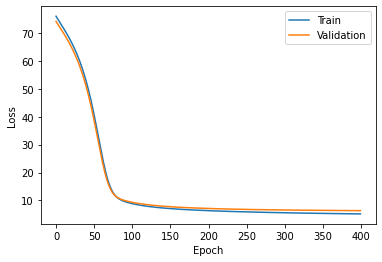

In [18]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
y_pred_test = model(torch.Tensor(X_test))

In [20]:
y_test = y_test.reshape(132)
y_pred_test = y_pred_test.reshape(132)

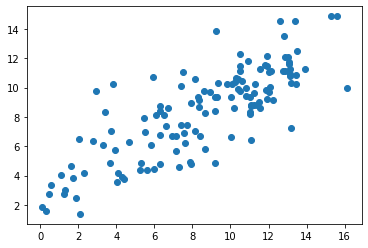

In [21]:
y_test = y_test.detach().numpy()
y_pred_test = y_pred_test.detach().numpy()
plt.scatter(y_test,y_pred_test)

In [22]:
print('R2 Score: ',R2Score(y_test, y_pred_test))

R2 Score:  0.6511174991562244


In [23]:
PearsonCoefficient(y_test, y_pred_test)

0.8078761510507967

In [24]:
import numpy as np
RMSE(y_test, y_pred_test)

2.255955